In [46]:
from models.resnet_model import get_resnet_model
import wandb
wandb.init() 
wandb.config.NUM_CLASSES = 3
from torchvision import transforms
from preprocessing.clahe import CLAHETransform
from dataset_handler.dataset import ImageDataset
import torch
wandb.config.USE_TRANSFORM_AUGMENTATION_IN_TRAINING = True
wandb.config.USE_CLAHE = False
wandb.config.TEST_DATA_DIR=r"data\test_metabolic\training_validation_datasets\step_5_cropped_square_adaptive_knee"
from torch.utils.data import DataLoader, WeightedRandomSampler
wandb.config.BATCH_SIZE = 32
wandb.config.NUM_WORKERS=1
import torch.nn as nn
wandb.config.DEVICE="cuda"
wandb.config.USE_OSTEOPENIA = True



In [47]:
size = (512, 512)
prepare_to_network_transforms = [
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]
augmentation_transform = [
    transforms.RandomRotation(degrees=10),  # Small random rotation
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Small shifts
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust contrast
]

all_transformation = []
train_transformations = []
if wandb.config.USE_TRANSFORM_AUGMENTATION_IN_TRAINING:
    train_transformations += augmentation_transform
if wandb.config.USE_CLAHE:
    all_transformation += (
        CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
    )  # Apply CLAHE with custom parameters

all_transformation += prepare_to_network_transforms
eval_transform = transforms.Compose(all_transformation)



test_dataset = ImageDataset(wandb.config.TEST_DATA_DIR)
test_dataset.transform = eval_transform



test_loader = DataLoader(
    test_dataset,
    batch_size=wandb.config.BATCH_SIZE,
    shuffle=False,
    num_workers=wandb.config.NUM_WORKERS,
)
# Define loss criterion
criterion = nn.CrossEntropyLoss()


In [48]:
from models.resnet_model import get_resnet_model

model = get_resnet_model(weights_path="saved_models/ResNet50_best.pth")
# model = get_resnet_model()


In [49]:
model.to(wandb.config.DEVICE)

model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(wandb.config.DEVICE)
        labels = labels.to(wandb.config.DEVICE)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)


        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())



avg_test_loss = test_loss / len(test_loader.dataset)
test_accuracy = correct / total



In [50]:
len(test_loader.dataset)

666

In [51]:
test_accuracy

0.933933933933934

In [52]:
print(all_labels,
all_preds,
all_probs)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [53]:
import pandas as pd
df = pd.DataFrame({
    'labels': all_labels,
    'preds': all_preds,
    'probs': all_probs
})

print(df)

     labels  preds                                     probs
0         0      0     [0.9141555, 0.0038183061, 0.08202623]
1         0      0     [0.73729706, 0.0018803627, 0.2608226]
2         0      0    [0.993537, 0.00039442698, 0.006068564]
3         0      0      [0.7108921, 0.003977712, 0.28513026]
4         0      0       [0.6843768, 0.09161836, 0.22400486]
..      ...    ...                                       ...
661       2      2     [0.068553835, 0.0011821255, 0.930264]
662       2      2  [0.041107412, 0.00072604715, 0.95816666]
663       2      0     [0.6123776, 0.0076069883, 0.38001543]
664       2      2  [0.0025670275, 0.00029249504, 0.9971404]
665       2      2   [0.006415362, 0.0015104396, 0.99207413]

[666 rows x 3 columns]


In [54]:
df

,labels,preds,probs
0,0,0,"[0.9141555, 0.0038183061, 0.08202623]"
1,0,0,"[0.73729706, 0.0018803627, 0.2608226]"
2,0,0,"[0.993537, 0.00039442698, 0.006068564]"
3,0,0,"[0.7108921, 0.003977712, 0.28513026]"
4,0,0,"[0.6843768, 0.09161836, 0.22400486]"
...,...,...,...
661,2,2,"[0.068553835, 0.0011821255, 0.930264]"
662,2,2,"[0.041107412, 0.00072604715, 0.95816666]"
663,2,0,"[0.6123776, 0.0076069883, 0.38001543]"
664,2,2,"[0.0025670275, 0.00029249504, 0.9971404]"


Text(0.5, 1.0, 'Confusion Matrix - ')

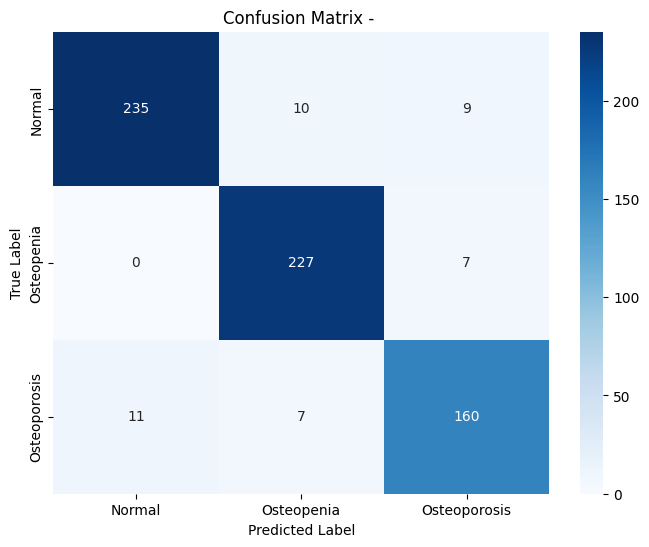

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
)
# Convert to numpy arrays
all_labels_np = np.array(all_labels)
all_preds_np = np.array(all_preds)
all_probs_np = np.array(all_probs)

cm = confusion_matrix(all_labels_np, all_preds_np)
class_names = ["Normal", "Osteopenia", "Osteoporosis"]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - ")


In [56]:
test_f1 = f1_score(all_labels_np, all_preds_np, average="macro")
test_precision = precision_score(all_labels_np, all_preds_np, average="macro")
test_recall = recall_score(all_labels_np, all_preds_np, average="macro")
all_labels_one_hot = np.eye(wandb.config.NUM_CLASSES)[all_labels_np]
test_auc = roc_auc_score(
    all_labels_one_hot, all_probs_np, average="macro", multi_class="ovr"
)


In [57]:
auc_str = f"{test_auc:.4f}"
print(
    f"[Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
    f"F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, AUC: {auc_str}"
)

[Test Loss: 0.2226, Test Accuracy: 0.9339, F1: 0.9312, Precision: 0.9316, Recall: 0.9314, AUC: 0.9845


In [65]:
import pandas as pd

# Load the copied Excel file
excel_path = r"c:\Users\e0l07sq\Desktop\rnd\osteoporosis_project\data\test_metabolic\patient_details_with_probs.csv"
df = pd.read_csv(excel_path)

# Ensure the DataFrame has the necessary structure
if 'probs' not in df.columns:
    df['probs_class_0'] = None
    df['probs_class_1'] = None
    df['probs_class_2'] = None

# Add prediction probabilities to the DataFrame
for idx, (label, pred, prob) in enumerate(zip(all_labels, all_preds, all_probs)):
    df.loc[idx, 'probs_class_0'] = prob[0]
    df.loc[idx, 'probs_class_1'] = prob[1]
    df.loc[idx, 'probs_class_2'] = prob[2]

# Save the updated DataFrame back to the Excel file
df.to_csv(excel_path, index=False)
print(f"Updated Excel file saved at: {excel_path}")

Updated Excel file saved at: c:\Users\e0l07sq\Desktop\rnd\osteoporosis_project\data\test_metabolic\patient_details_with_probs.csv
